In [2]:
CONSTRAINT_TOOLS = '/scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools'
CONSTRAINT_TOOLS_DATA = '/scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools'

import sys
sys.path.append(f'{CONSTRAINT_TOOLS}/utilities')

## Non-exonic windows, with Gnocchi and various features (e.g. GC content), and enhancer-overlap status 

In [3]:
import pandas as pd
from functools import reduce

def get_windows_with_GC_content_and_cpg_islands(): 
  df1 = pd.read_csv(
    f'{CONSTRAINT_TOOLS_DATA}/chen-et-al-2023-published-version/41586_2023_6045_MOESM4_ESM/Supplementary_Data_2.gnocchi.N_expected.N_observed.B.paternal_recombination_rate.maternal_recombination_rate.gBGC-tract-counts.non-exonic.gBGC.bed', 
    sep='\t', 
  )

  for gc_window_size in [
    1000, 
    10000, 
    100000,
    1000000,
  ]:
    df_temp = pd.read_csv(
      f'{CONSTRAINT_TOOLS_DATA}/chen-et-al-2023-published-version/41586_2023_6045_MOESM4_ESM/Supplementary_Data_2.GC_content_{gc_window_size}.bed', 
      sep='\t', 
    )
    df_temp = df_temp[['chen_chrom', 'chen_start', 'chen_end', 'window_GC_content']]
    df_temp = df_temp.rename(columns={
      'chen_chrom': 'chrom', 
      'chen_start': 'start', 
      'chen_end': 'end',
      'window_GC_content': f'GC_content_{gc_window_size}bp'
    })
    df1 = pd.merge(df1, df_temp, on=['chrom', 'start', 'end'], how='inner')

  # created using: experiments/germline-model/chen-et-al-2022/cpg-island-enrichment.ipynb
  df2 = pd.read_csv(
    f'{CONSTRAINT_TOOLS_DATA}/benchmark-genome-wide-predictions/chen-et-al-2022/mchale.kmerSizes.trainSets.noisy.enhancer-exon-cpgIsland.bed',
    sep='\t', 
  )
  df2 = df2[['chromosome', 'start', 'end', 'cpg_island overlap', 'window overlaps cpg_island']]
  df2 = df2.rename(columns={
    'chromosome': 'chrom', 
    'cpg_island overlap': 'cpg_island_overlap', 
    'window overlaps cpg_island': 'window_overlaps_cpg_island'
  })

  dfs = [df1, df2]
  df = reduce(lambda left, right: pd.merge(left, right, on=['chrom', 'start', 'end'], how='inner'), dfs)

  return df

WINDOWS = get_windows_with_GC_content_and_cpg_islands()
WINDOWS 

,chrom,start,end,gnocchi,N_expected,N_observed,window overlaps enhancer,window overlaps merged_exon,B,paternal_recombination_rate,...,B0_M3starHMT6.EUR,B1_M3starHMT6.EUR,Bmean_M3starHMT6.EUR,lambda_M3starHMT6.EUR,GC_content_1000bp,GC_content_10000bp,GC_content_100000bp,GC_content_1000000bp,cpg_island_overlap,window_overlaps_cpg_island
0,chr1,1432000,1433000,4.299894,338.059552,259,True,False,0.653,0.039046,...,0.057741,0.513191,0.105518,2.585568,0.661339,0.641836,0.565094,0.577534,NaN,False
1,chr1,1451000,1452000,0.666316,302.590657,291,False,False,0.652,0.039046,...,0.057741,0.513191,0.105518,2.585568,0.556444,0.552845,0.572894,0.575506,NaN,False
2,chr1,1453000,1454000,0.828398,269.601925,256,False,False,0.651,0.039046,...,0.057741,0.513191,0.105518,2.585568,0.537463,0.561944,0.572564,0.575129,NaN,False
3,chr1,1458000,1459000,-0.086128,270.583243,272,False,False,0.651,0.039046,...,0.057741,0.513191,0.105518,2.585568,0.532468,0.596740,0.570774,0.575225,NaN,False
4,chr1,1463000,1464000,2.948188,236.321790,191,True,False,0.651,0.039046,...,0.057741,0.513191,0.105518,2.585568,0.540460,0.568843,0.576514,0.574420,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019146,chr9,137262000,137263000,-2.396149,263.131293,302,True,False,0.536,0.057053,...,0.135944,3.636507,0.219258,2.281162,0.500499,0.542646,0.611944,0.568316,45.0,True
1019147,chr9,137268000,137269000,3.640544,272.046527,212,True,False,0.536,0.057053,...,0.135944,3.636507,0.219258,2.281162,0.552448,0.589941,0.613074,0.567839,NaN,False
1019148,chr9,137269000,137270000,5.276351,300.458958,209,True,False,0.536,0.057053,...,0.135944,3.636507,0.219258,2.281162,0.519481,0.585042,0.613494,0.567623,NaN,False
1019149,chr9,137275000,137276000,2.687348,339.517045,290,True,False,0.536,1.564889,...,0.135944,3.636507,0.219258,2.281162,0.603397,0.639236,0.610484,0.567380,NaN,False


## Central Limit Theorem (CLT) predicts that z-scores should be standard-normal distributed

The number of distinct ALT alleles $N_i$ at a site $i$ is a categorical variable with site-dependent mean $\langle N_i \rangle$ and variance $\text{var} (N_i)$. (See [model](https://github.com/quinlan-lab/constraint-tools/blob/main/define-model/germline-model.ipynb).) Since these random variables are independent, but not identically distributed, the [Lyapunov CLT](https://en.wikipedia.org/wiki/Central_limit_theorem#Lyapunov_CLT) applies. This theorm states that, if the number of sites $l$ in a window is large enough (we consider $l=1000$), then $N = \sum_i N_i$ is distributed as: 

\begin{equation}
\frac{N - \langle N \rangle}{\sqrt{\text{var}(N)}} \sim \text{Normal}(0, 1) 
\end{equation}

where 

$$ 
\langle N \rangle = \sum_i \langle N_i \rangle 
$$ 

and 

$$ 
\text{var}(N) = \sum_i \text{var}(N_i).
$$


If one simulates many windows, and generates a single SNV count for each window, then the distribution of z-scores of those windows will be a standard normal. 


Based on: experiments/germline-model/chen-et-al-2022/null-distribution-is-normal.ipynb

## The distribution of Gnocchi is not standard-normal

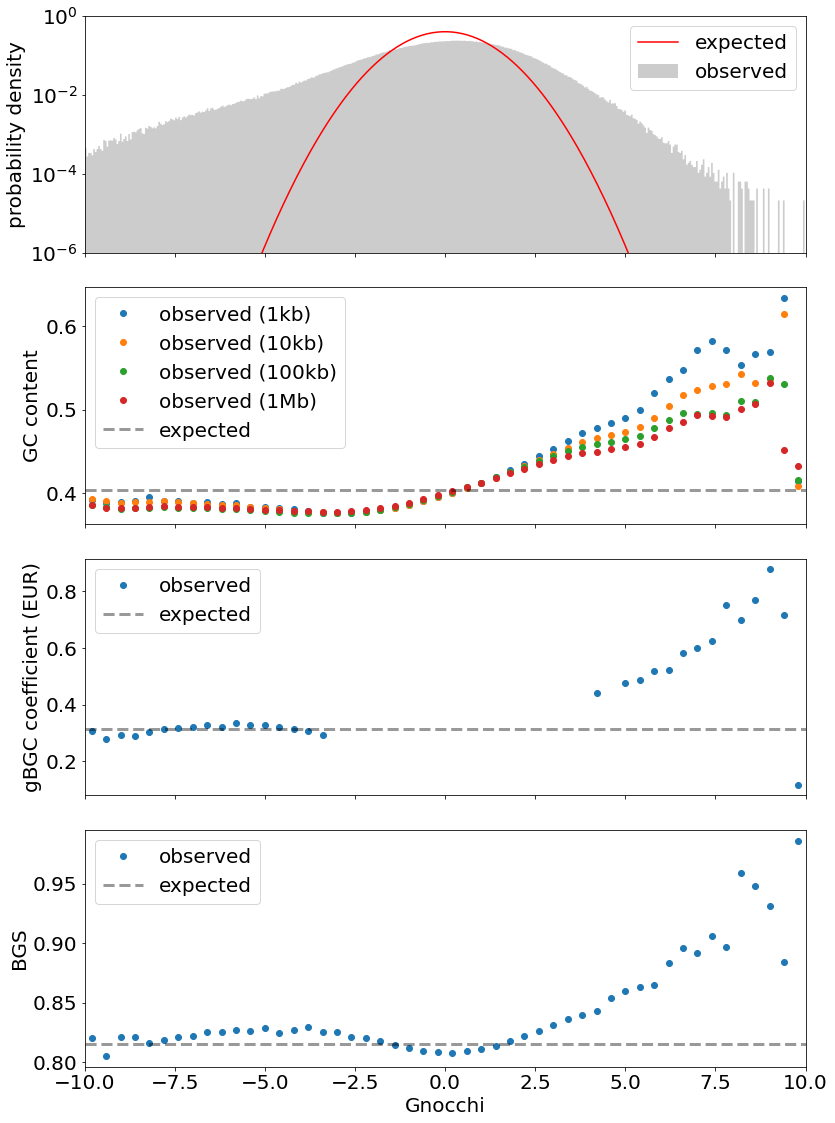

In [6]:
import matplotlib.pyplot as plt 
plt.rcParams.update({
    'font.size': 20,
    'figure.figsize': (12, 6)
})

import numpy as np 
from scipy import stats
from scipy.stats import norm

def create_label(length): 
    if length < 1000: 
        return f'observed ({length}bp)'
    elif length < 1000000: 
        return f'observed ({int(length/1000)}kb)'
    else: 
        return f'observed ({int(length/1000000)}Mb)'
    
def plot_mean_feature_vs_zscore(df, feature, ax, label): 
    bin_means, bin_edges, _ = stats.binned_statistic(df['gnocchi'], df[feature], statistic='mean', bins=50, range=(-10, 10))
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    ax.plot(bin_centers, bin_means, marker='o', linestyle='', label=label)

def plot_distribution_of_zscores_and_other_features(df): 
    fig, axs = plt.subplots(4, 1, figsize=(12, 16), sharex=True)

    # Plot the distribution of zscores
    _, bins, _ = axs[0].hist(df['gnocchi'], density=True, bins='auto', histtype='stepfilled', alpha=0.2, label='observed', color='black')
    axs[0].plot(bins, norm.pdf(bins), label='expected', color='red')
    axs[0].set_ylabel('probability density')
    axs[0].set_xlim([-10, 10])
    axs[0].set_yscale('log')
    axs[0].set_ylim([1e-6, 1])
    axs[0].legend()

    for gc_window_size in [1000, 10000, 100000, 1000000]:
        plot_mean_feature_vs_zscore(
            df, 
            feature=f'GC_content_{gc_window_size}bp', 
            ax=axs[1], 
            label=create_label(gc_window_size)
        )
    mean_gc_content = df[f'GC_content_1000bp'].mean()
    axs[1].axhline(mean_gc_content, linestyle='--', linewidth=3, color='black', alpha=0.4, label='expected')
    axs[1].set_ylabel('GC content')
    axs[1].legend()

    gBGC = 'B_M1star.EUR'
    plot_mean_feature_vs_zscore(
        df, 
        feature=gBGC, 
        ax=axs[2], 
        label='observed'
    )
    mean_gBGC = df[gBGC].mean()
    axs[2].axhline(mean_gBGC, linestyle='--', linewidth=3, color='black', alpha=0.4, label='expected')
    axs[2].set_ylabel('gBGC coefficient (EUR)')
    axs[2].legend()

    BGS = 'B'
    plot_mean_feature_vs_zscore(
        df, 
        feature=BGS, 
        ax=axs[3], 
        label='observed'
    )
    mean_BGS = df[BGS].mean()
    axs[3].axhline(mean_BGS, linestyle='--', linewidth=3, color='black', alpha=0.4, label='expected')
    axs[3].set_xlabel('Gnocchi')
    axs[3].set_ylabel('BGS')
    axs[3].legend()

    plt.tight_layout()
    plt.show()

plot_distribution_of_zscores_and_other_features(WINDOWS)

In [ ]:
# TODO 

# a. experiments/germline-model/chen-et-al-2022/compare-mchale-and-chen-windows.ipynb
# b. experiments/germline-model/chen-et-al-2022/QQ-plot-for-noncoding-windows.ipynb
# 1. Use CLT to compute a p-value: the probability of observing a SNV count under the null (gausssian) that is greater than the observed SNV count
# 2. rank observed and expected p-values, and plot the QQ plot, colloring the data points by GC content 


